In [1]:
import json
import datetime

import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import numpy as np

# Select coordinates range

In [34]:
filter_list = [[-12.216796875000002,59.40036514079251],[25.576171875,59.40036514079251],[25.576171875,36.10237644873644],[-12.216796875000002,36.10237644873644],[-12.216796875000002,59.40036514079251]] # europe
# filter_list = [[-10.898437500000002,34.59704151614417],[34.10156250000001,34.59704151614417],[34.10156250000001,-35.17380831799957],[-10.898437500000002,-35.17380831799957],[-10.898437500000002,34.59704151614417]] # africa
# filter_list = [[-125.06835937500001,45.767522962149904],[-116.982421875,45.767522962149904],[-116.982421875,31.728167146023935],[-125.06835937500001,31.728167146023935],[-125.06835937500001,45.767522962149904]] # california
filters_str = json.dumps(filter_list, separators=(",", ":"))


In [2]:
# response = requests.get(f"http://127.0.0.1:9999/earthquake?coordinates={filters_str}&date_start=2015-01-01")
# response = requests.get(f"http://127.0.0.1:9999/earthquake?coordinates={filters_str}&date_start=2015-07-01&date_end=2016-07-01")
# response = requests.get(f"http://127.0.0.1:9999/earthquake?coordinates={filters_str}")
response = requests.get(f"http://127.0.0.1:9999/earthquake")
response_dict = response.json()

# Convert backend data to DataFrame

In [43]:
"""Convert response to pandas"""
eq_list = []
for eq in response_dict['data']:
    timestamp = datetime.datetime.fromtimestamp(eq['time']//1000)
    dataframe_fields = {
        "id": eq['id'],
        "mag": eq['mag'],
        "time": datetime.datetime.fromtimestamp(eq['time']//1000),
    }
    eq_list.append(dataframe_fields)

df = pd.DataFrame(eq_list)
df

,id,mag,time
0,1,1.93,1995-01-28 00:58:26
1,2,1.90,1995-01-28 00:55:35
2,3,3.50,1995-01-28 00:53:30
3,4,1.76,1995-01-28 00:44:05
4,5,1.62,1995-01-28 00:39:14
...,...,...,...
3292372,3292373,1.00,2023-03-21 01:22:45
3292373,3292374,4.50,2023-03-21 01:20:14
3292374,3292375,1.00,2023-03-21 01:16:18
3292375,3292376,1.06,2023-03-21 01:06:09


In [5]:
"""Convert response to pandas - whole object"""
print(response_dict['data'][0])
eq_list = []
for eq in response_dict['data']:
    timestamp = datetime.datetime.fromtimestamp(eq['time']//1000)
    dataframe_fields = {
        "id": eq['id'],
        "mag": eq['mag'],
        "time": datetime.datetime.fromtimestamp(eq['time']//1000),
        "latitude": eq['geometry']['coordinates'][1],
        "longitude": eq['geometry']['coordinates'][0],
        "height": eq['geometry']['coordinates'][2],
    }
    eq_list.append(dataframe_fields)

df = pd.DataFrame(eq_list)
df

{'id': 1, 'mag': 1.93, 'date': '1995-01-28', 'geometry': {'type': 'Point', 'coordinates': [-118.6871667, 37.4395, 4.901], 'bbox': None}, 'id_geom': 'nc30066945', 'type': 'earthquake', 'time': 791251106810}


,id,mag,time,latitude,longitude,height
0,1,1.93,1995-01-28 00:58:26,37.439500,-118.687167,4.901
1,2,1.90,1995-01-28 00:55:35,34.418000,-116.486000,4.484
2,3,3.50,1995-01-28 00:53:30,36.045000,-1.075000,33.000
3,4,1.76,1995-01-28 00:44:05,40.454000,-123.886833,3.975
4,5,1.62,1995-01-28 00:39:14,35.033000,-117.683000,-0.935
...,...,...,...,...,...,...
3292372,3292373,1.00,2023-03-21 01:22:45,58.205500,-155.127300,14.400
3292373,3292374,4.50,2023-03-21 01:20:14,38.997100,21.137600,10.000
3292374,3292375,1.00,2023-03-21 01:16:18,63.526200,-148.426700,6.800
3292375,3292376,1.06,2023-03-21 01:06:09,37.604000,-121.722833,5.990


# Save DataFrame from pickled file

In [6]:
# pickling
df.to_pickle('./earthquakes_with_coordinates.pkl')

# Load DataFrame from pickled file

In [7]:
# unpickling
df = pd.read_pickle('./earthquakes_with_coordinates.pkl')
df.head()

,id,mag,time,latitude,longitude,height
0,1,1.93,1995-01-28 00:58:26,37.4395,-118.687167,4.901
1,2,1.90,1995-01-28 00:55:35,34.4180,-116.486000,4.484
2,3,3.50,1995-01-28 00:53:30,36.0450,-1.075000,33.000
3,4,1.76,1995-01-28 00:44:05,40.4540,-123.886833,3.975
4,5,1.62,1995-01-28 00:39:14,35.0330,-117.683000,-0.935


In [ ]:
plt.figure(figsize=(25,6))
date_start = datetime.datetime(1995,2,1,0,0,0)
date_end = datetime.datetime(1998,4,15,0,0,0)

filtered = df[(date_start <= df['time']) & (df['time'] <= date_end)]

plt.scatter(filtered['time'], filtered['mag'], s=[3])
len(filtered)

In [9]:
magnitudes2 = df[['mag', 'time']]
magnitudes2['date'] = magnitudes2['time'].dt.date


magnitudes = magnitudes2['mag']
magnitudes.index = magnitudes2['time']

In [10]:
# sort index days
magnitudes.sort_index(inplace=True)

In [37]:
magnitudes.index.nunique()

3284297

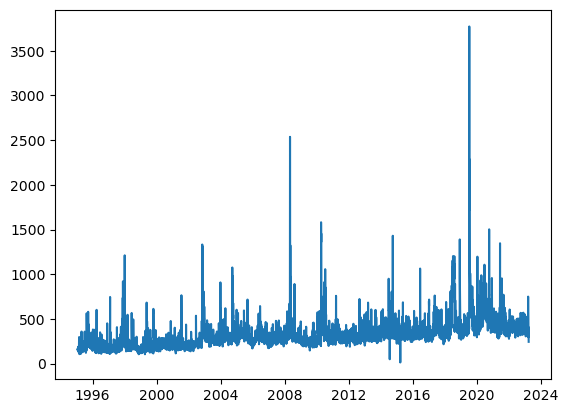

In [8]:
# get count per day
day_count = magnitudes.groupby(magnitudes['date']).size().reset_index(name='count')
# somer = magnitudes.date.value_counts().reset_index(name='count')

plt.plot(day_count['date'], day_count['count'])
# day_count[:5]

# Setting training and testing datasets

In [66]:
# day_count=magnitudes.date.value_counts(normalize=False)
# day_count[:5]

date
2019-07-06    3772
2019-07-05    2909
2008-04-27    2537
2008-04-26    2523
2019-07-09    2287
Name: count, dtype: int64

In [14]:
# magnitudes = magnitudes[['mag', 'time']]
# magnitudes
# magnitudes = magnitudes[magnitudes.index <= datetime.date(2025, 1, 1)]

# training_earthquakes = magnitudes.index <= '2020-05-28'  # 90% of 10281 days
# training_earthquakes = magnitudes.loc['1995-01-28':'`2020-05-28']  # 90% of 10281 days
training_earthquakes = magnitudes.loc['1995-01-28':'1995-02-05']  # 90% of 10281 days
training_earthquakes

time
1995-01-28 00:02:51    1.67
1995-01-28 00:04:07    4.30
1995-01-28 00:04:16    0.70
1995-01-28 00:16:47    1.90
1995-01-28 00:17:59    4.70
                       ... 
1995-02-05 23:32:05    3.70
1995-02-05 23:37:47    1.85
1995-02-05 23:51:05    7.10
1995-02-05 23:51:08    0.92
1995-02-05 23:59:16     NaN
Name: mag, Length: 1386, dtype: float64

# Find P

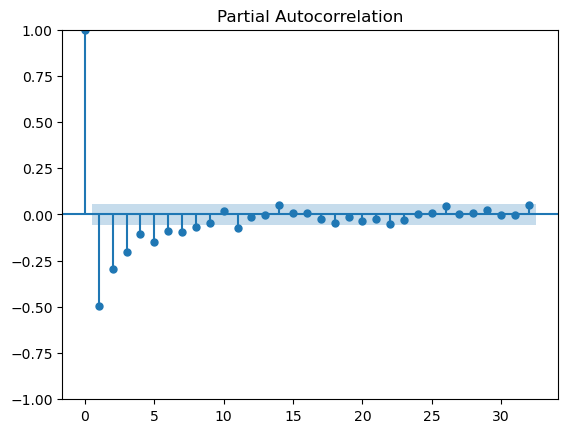

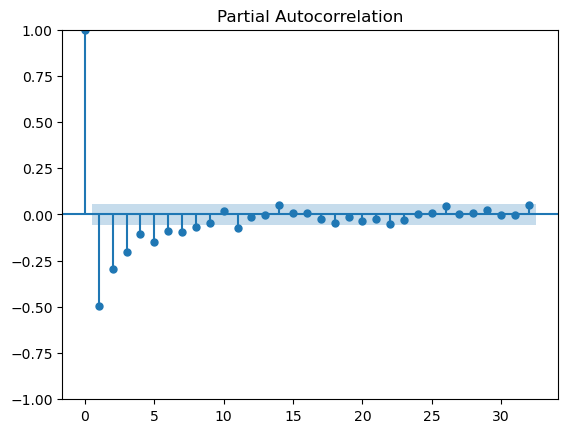

In [15]:
# Finding P
plot_pacf(training_earthquakes.diff().dropna())

# Find D

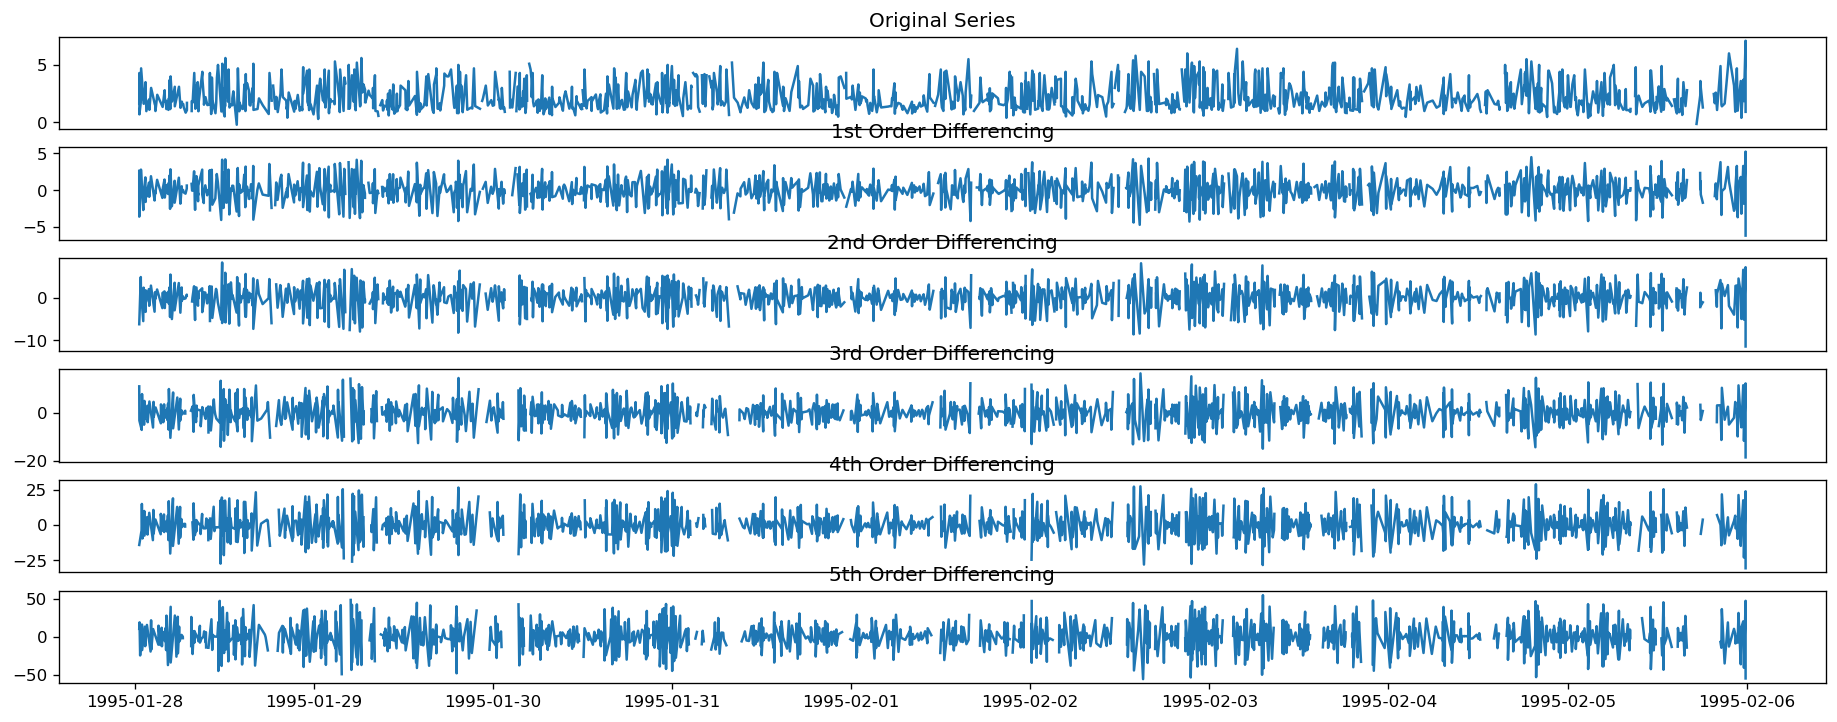

In [16]:
# Finding D
plt.rcParams.update({'figure.figsize':(19,7), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)
ax1.plot(training_earthquakes); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(training_earthquakes.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(training_earthquakes.diff().diff()); ax3.set_title('2nd Order Differencing'); ax3.axes.xaxis.set_visible(False)
# 3rd Differencing
ax4.plot(training_earthquakes.diff().diff().diff()); ax4.set_title('3rd Order Differencing'); ax4.axes.xaxis.set_visible(False)
# 4th Differencing
ax5.plot(training_earthquakes.diff().diff().diff().diff()); ax5.set_title('4th Order Differencing'); ax5.axes.xaxis.set_visible(False)
# 5th Differencing
ax6.plot(training_earthquakes.diff().diff().diff().diff().diff()); ax6.set_title('5th Order Differencing')
plt.show()

# Find Q

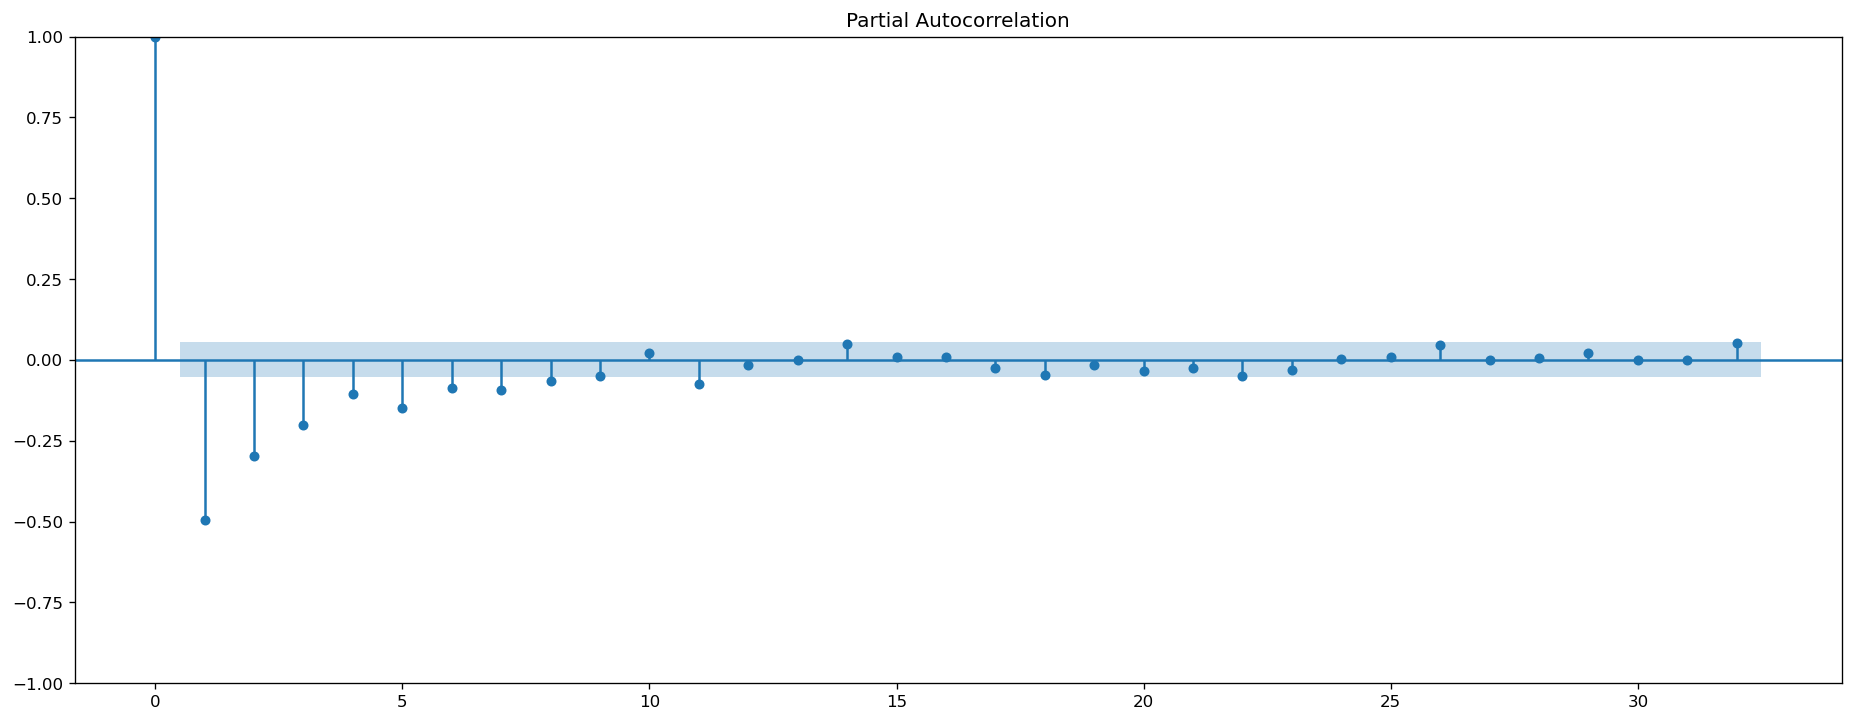

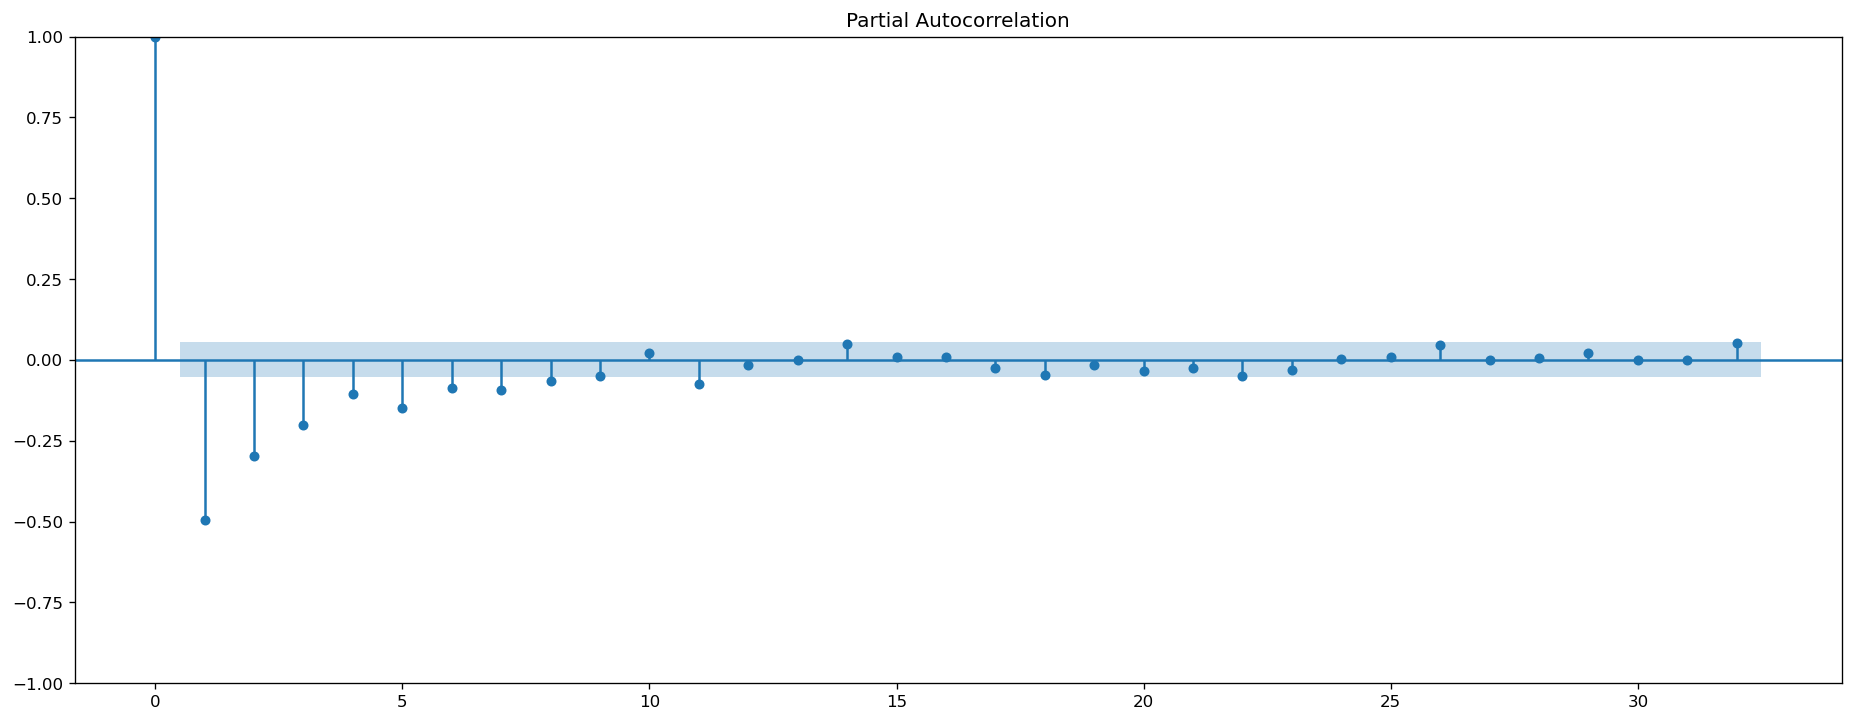

In [17]:
# Finding Q
plot_pacf(training_earthquakes.diff().dropna())

In [63]:
model = ARIMA(training_earthquakes, order=(1, 0, 6))
# model = SARIMAX(training_earthquakes, order=(3, 1, 2))
model_fit = model.fit()

C:\Users\sirko\.conda\envs\backend\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sirko\.conda\envs\backend\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sirko\.conda\envs\backend\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    mag   No. Observations:                 1386
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -2414.657
Date:                Tue, 26 Mar 2024   AIC                           4835.314
Time:                        19:35:37   BIC                           4851.012
Sample:                             0   HQIC                          4841.186
                               - 1386                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5257      0.024    -21.919      0.000      -0.573      -0.479
ma.L1         -1.0000      1.511     -0.662      0.508      -3.962       1.962
sigma2         2.1110      3.187      0.662      0.508      -4.135       8.357
===================================================================================
Ljung-Box (L1) (Q):                  37.80   Jarque-Bera (JB):                48.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.45
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predicting

In [27]:
# testing_earthquakes = magnitudes.loc['2020-05-28':'2025-01-01']
testing_earthquakes = magnitudes.loc['1995-02-05':'1995-02-06']

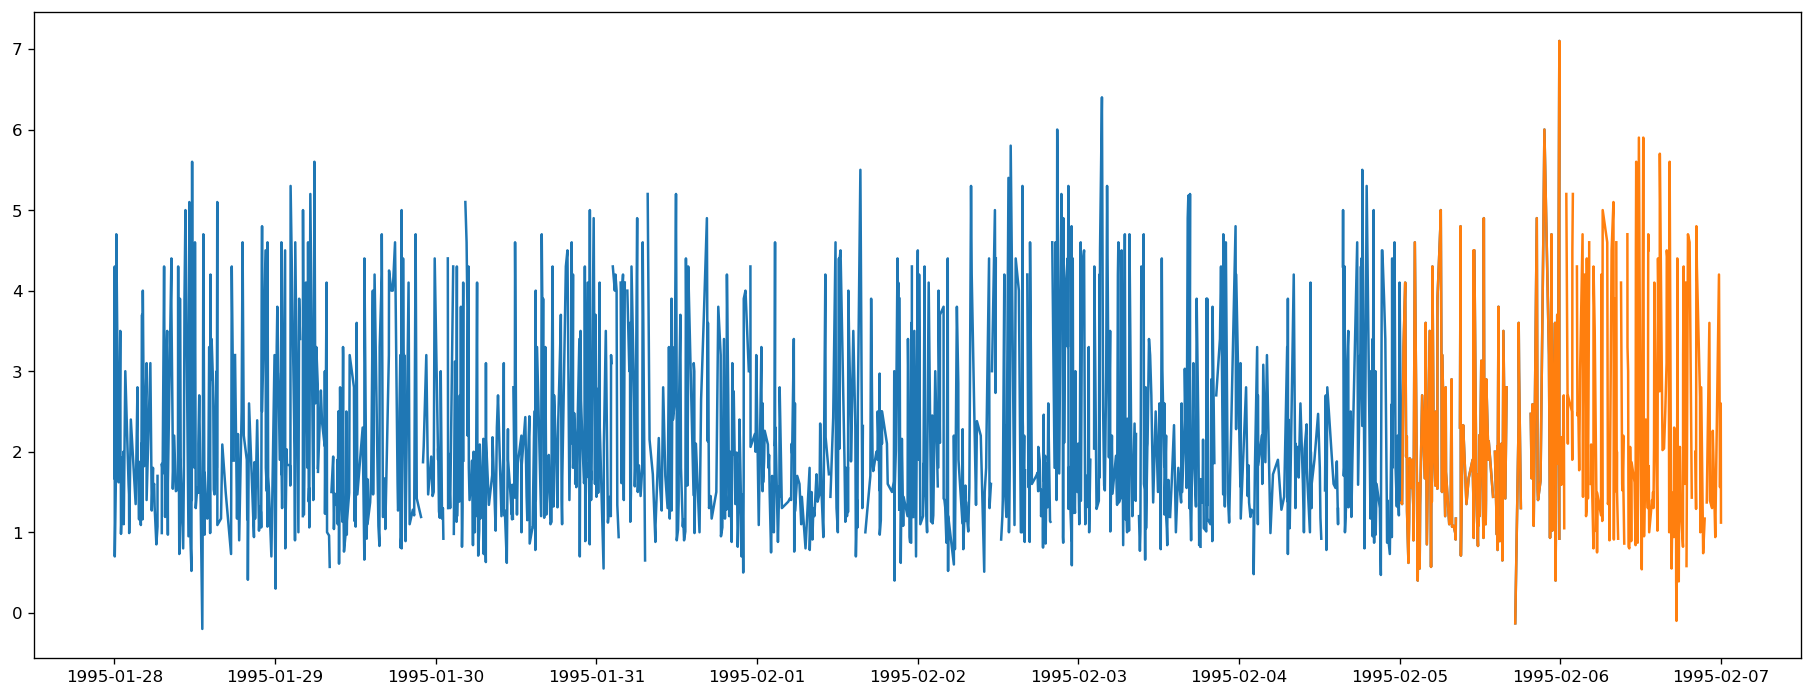

In [45]:
# y_pred = model_fit.get_forecast(len(testing_earthquakes.index))
plt.plot(training_earthquakes)
plt.plot(testing_earthquakes)
# y_pred_df = y_pred.conf_int(alpha = 0.05)
# y_pred_df["Predictions"] = model_fit.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
# y_pred_df.index = model_fit.index
# y_pred_out = y_pred_df["Predictions"]
# plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
# plt.legend()


In [35]:
testing_earthquakes

time
1995-02-05 00:16:16    1.37
1995-02-05 00:21:39    1.35
1995-02-05 00:34:52    3.30
1995-02-05 00:49:36    4.10
1995-02-05 00:58:01    1.94
                       ... 
1995-02-06 23:16:05    1.72
1995-02-06 23:41:47    4.20
1995-02-06 23:50:59    1.56
1995-02-06 23:57:41    2.60
1995-02-06 23:59:39    1.12
Name: mag, Length: 322, dtype: float64

C:\Users\sirko\.conda\envs\backend\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sirko\.conda\envs\backend\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sirko\.conda\envs\backend\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


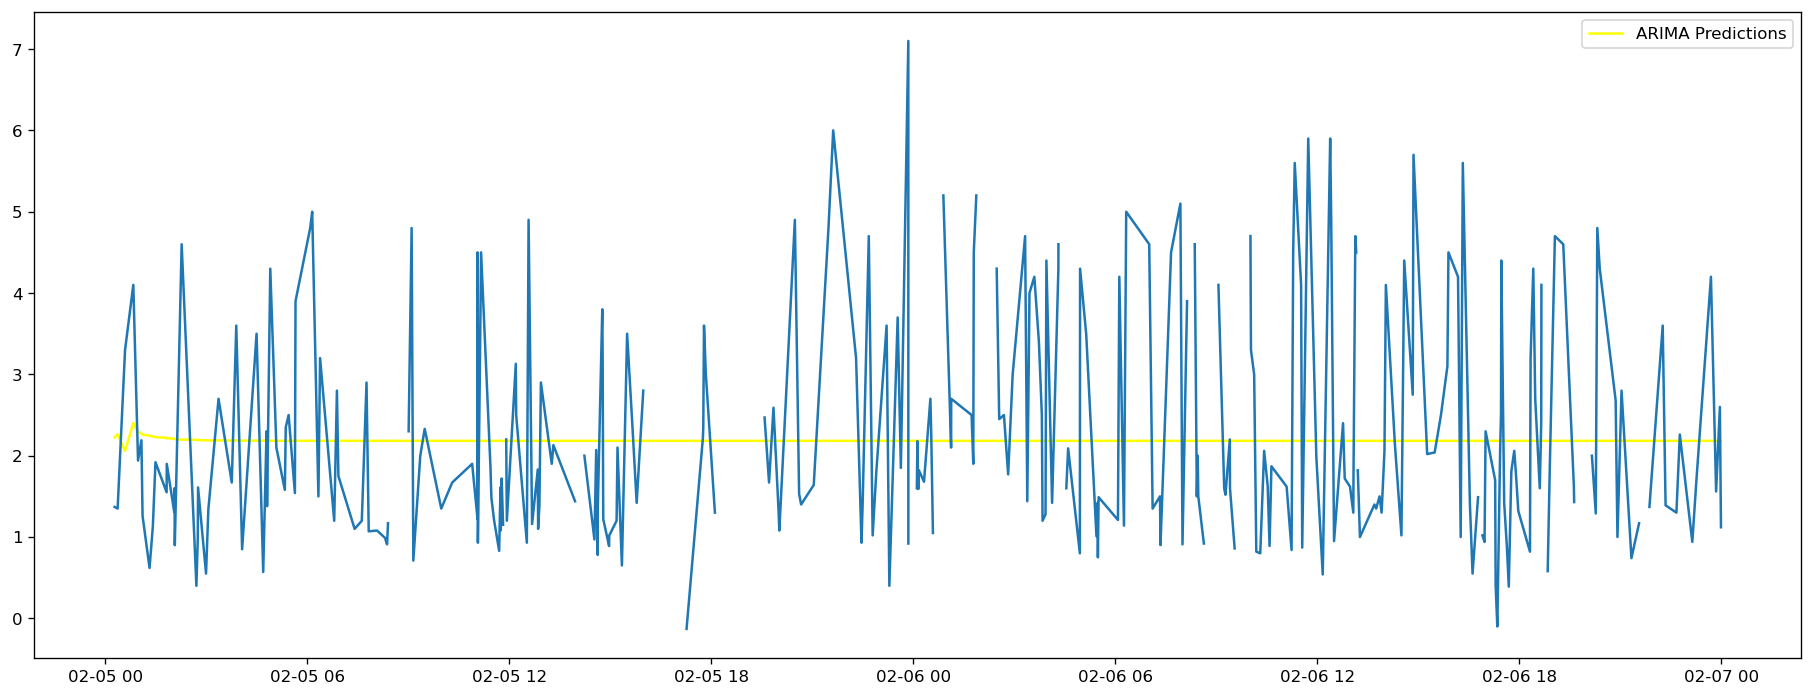

In [64]:
y_pred = model_fit.get_forecast(len(testing_earthquakes.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = model_fit.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = testing_earthquakes.index
y_pred_out = y_pred_df["Predictions"]
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.plot(testing_earthquakes)
plt.legend()